In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# originalData=pd.read_csv('./data/2015_Street_Tree_Census.csv')
originalData=pd.read_csv('./data/2015_tree_process.csv',dtype={'zipcode':str})
originalData.head(2)

,tree_id,borough,zipcode,latitude,longitude,tree_dbh,spc_common,health,Median_Individual_Income,Median_Resident_Age,...,post_office,neighborhood,population,density,family,health_class,borough_class,tree_class,tree_family_class,comlaint_count
0,180683,Queens,11375,40.723092,-73.844215,3,red maple,Fair,84617.0,43.5,...,"Forest Hills, NY",West Central Queens,68733,34707,Aceraceae,2,1,1.0,0,783.0
1,203550,Queens,11375,40.713170,-73.854446,42,London planetree,Good,84617.0,43.5,...,"Forest Hills, NY",West Central Queens,68733,34707,Platanaceae,1,1,1.0,1,783.0


In [2]:
originalData.columns

Index(['tree_id', 'borough', 'zipcode', 'latitude', 'longitude', 'tree_dbh',
       'spc_common', 'health', 'Median_Individual_Income',
       'Median_Resident_Age', 'Median_Monthly_House_Cost', 'post_office',
       'neighborhood', 'population', 'density', 'family', 'health_class',
       'borough_class', 'tree_class', 'tree_family_class', 'comlaint_count'],
      dtype='object')

In [3]:
originalData.dtypes

tree_id                        int64
borough                       object
zipcode                       object
latitude                     float64
longitude                    float64
tree_dbh                       int64
spc_common                    object
health                        object
Median_Individual_Income     float64
Median_Resident_Age          float64
Median_Monthly_House_Cost    float64
post_office                   object
neighborhood                  object
population                     int64
density                        int64
family                        object
health_class                   int64
borough_class                  int64
tree_class                   float64
tree_family_class              int64
comlaint_count               float64
dtype: object

In [186]:
selectedNames = ['spc_common','family','latitude','longitude','zipcode','health','comlaint_count']
health_map1 = {'Good': 1, 'Fair': 0.5, 'Poor': 0, 'Dead': -1}
health_map2 = {'Good': 1, 'Fair': 0, 'Poor': 0, 'Dead': 0}

data = originalData[selectedNames]
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

data['health_class'] = data.loc[:,'health'].map(health_map1)
data.shape

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ainde\AppData\Local\Temp/ipykernel_14152/1117065738.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['health_class'] = data.loc[:,'health'].map(health_map1)


(639827, 8)

In [144]:
data.head(2)

,family,latitude,longitude,zipcode,health,comlaint_count,health_class
0,Aceraceae,40.723092,-73.844215,11375,Fair,783.0,0.5
1,Platanaceae,40.713170,-73.854446,11375,Good,783.0,1.0


In [4]:
x_min, x_max = data['longitude'].min() - 0.05, data['longitude'].max() + 0.05
y_min, y_max = data['latitude'].min() - 0.05, data['latitude'].max() + 0.05

h = .02  # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
z_sum = [0] * (xx.shape[0] * xx.shape[1])

In [10]:
cnt = 0
n_splits = 131

kf = KFold(n_splits=n_splits, random_state=None, shuffle=True)
for train_index, test_index in kf.split(data):
    x = data['longitude'].iloc[test_index]
    y = data['latitude'].iloc[test_index]
    z = data['health_class'].iloc[test_index]

    kernel = 1. * RBF(length_scale=[1.0,1.0], length_scale_bounds=[(1e-3, 1e3),(1e-3, 1e3)]) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))
    gp = GaussianProcessRegressor(kernel=kernel,random_state=1)

    gp.fit(np.c_[x,y], z)
    z_pred = gp.predict(np.c_[xx.ravel(), yy.ravel()])
    z_sum += z_pred

    cnt += 1

    print(f'Iter {cnt}: ', z_pred.min(), z_pred.max())
    print('Optimized kernel: ', gp.kernel_)
    print('Log marginal likelihood: ', gp.log_marginal_likelihood_value_)
    print('---------------------------------------------------------------------------------')

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 1:  0.875824884541295 0.8902600989361886
Iter 2:  0.49188973535842706 1.0276331482837264
Iter 3:  0.38170505108895014 1.083777426967373


D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 4:  0.8854910707470083 0.8855146314777187
Iter 5:  0.4790269320573657 0.9866820864451498
Iter 6:  0.003458360807004013 0.9317106612602677
Iter 7:  0.2846473834889025 0.9477320950336008
Iter 8:  0.3790885213263948 1.0811924676300215


D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 9:  0.8730532182000275 0.8876542905696851
Iter 10:  0.4576931228279406 0.9995371676798861
Iter 11:  0.2535957396019848 1.0766089694863972
Iter 12:  0.6389879112176189 0.9393345608706483
Iter 13:  0.7107608571514348 0.9631681635680138
Iter 14:  0.7638804799467209 0.9234863878037913
Iter 15:  0.5122436563880939 0.9727856618696293
Iter 16:  0.4431439228085168 1.0919498739442588
Iter 17:  0.4703713598909012 1.0451225619808842
Iter 18:  0.48304153247577375 0.9531715568993917
Iter 19:  0.4312350358018211 0.9995597945718941
Iter 20:  0.39008211509894153 1.0166055122022684
Iter 21:  0.39127967908392236 1.0432577559527871
Iter 22:  0.4974255562958003 0.9211578418886113
Iter 23:  0.5569972635940701 0.9515225050805185
Iter 24:  0.36054160952848235 0.9609868479094175
Iter 25:  0.5724728322726378 0.9530118166628867


D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 26:  0.8623901756388079 0.8933170432675297
Iter 27:  0.33264857637388445 1.0122014527084247
Iter 28:  0.13024453369593658 1.073223090908563
Iter 29:  0.43685825692109503 1.023067466046565
Iter 30:  0.4087256358370883 0.9768707026565204
Iter 31:  0.6684045201164928 0.9134326762948604
Iter 32:  0.394835918328198 0.9751810201425286
Iter 33:  0.5048102942038 0.9858887782027281


D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 34:  0.8850948636472786 0.8851086421982082
Iter 35:  0.4412246781325706 1.028955588080251
Iter 36:  0.3759472534655153 0.9555101116420075
Iter 37:  0.3551747223970132 0.9438332259477686
Iter 38:  0.4521398402286403 1.0552772987979608
Iter 39:  0.48867048030434646 0.9880051872911082
Iter 40:  0.1934753877085953 1.0736459031091456
Iter 41:  0.2974214814191507 0.9615257625701368
Iter 42:  0.5086393447558333 1.054782607274575
Iter 43:  0.4109351428772925 0.9390627245573953
Iter 44:  0.41332594026147973 0.9899837813350629


D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 45:  0.8419781091819161 0.9172235979701782
Iter 46:  0.44633765941770775 0.975759265177885
Iter 47:  0.5382737045773638 1.0750071258872254
Iter 48:  0.5670222388524166 0.9164024969148983
Iter 49:  0.814024206329222 0.9421109323573091
Iter 50:  0.2576998959272032 0.9499505668464323
Iter 51:  0.37250306301325864 0.9381024536743396
Iter 52:  0.056817150710795516 0.9783989640995472
Iter 53:  0.5204333113254975 0.9470361629143511
Iter 54:  0.3698778114082515 1.0304381429290856
Iter 55:  0.6575361820640069 0.9652847630657284
Iter 56:  0.4773530728375448 1.0828031115504757
Iter 57:  0.6474586972594523 1.0684721956637482
Iter 58:  -0.17400948635854974 1.2902715324362823
Iter 59:  0.4706256141421754 1.0758280322271503
Iter 60:  0.3836488274262724 1.0168747674266392


D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 61:  0.8836699196088773 0.8836770927052982
Iter 62:  0.6689843217384492 0.9113267544297656
Iter 63:  0.31526665737311 1.0007118570814306
Iter 64:  0.558615092899899 1.0274930052012685
Iter 65:  0.36442899481095736 1.025593076708013


D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 66:  0.8802853319843109 0.8804093216244269
Iter 67:  0.17665013066036295 0.9616311625557223
Iter 68:  0.24034074287654406 0.9824192383574832
Iter 69:  0.21790847760016518 0.9398704459051714
Iter 70:  0.664809156182713 0.92474811851082
Iter 71:  0.6359465554987409 0.9380999347318433
Iter 72:  0.42096388107828986 1.0002944405427634
Iter 73:  0.36381477975819365 0.9590937946732865
Iter 74:  0.12300501466150848 0.945294298068692
Iter 75:  -0.32979270243517966 1.107706909015704
Iter 76:  0.529613124412748 1.0344801590941728
Iter 77:  0.39002373629323017 1.0430381274235856
Iter 78:  0.831869168482001 0.9227454633894965
Iter 79:  0.5246958988050778 1.036818210074344
Iter 80:  0.06329636843061515 0.9485036015234982
Iter 81:  0.5050143275180261 1.029830407927335
Iter 82:  0.37896169863047646 1.0370131012630353
Iter 83:  0.2541226474419993 0.9533902959488252
Iter 84:  -0.19779328598600188 0.9628130247076783
Iter 85:  0.6488658573591835 0.9514362452373675
Iter 86:  0.3717936328002054 1.08021

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 96:  0.8873839142906945 0.8873942691611774
Iter 97:  0.396516679164737 1.0040137696617428
Iter 98:  0.41158490600003006 1.07404103439481
Iter 99:  0.4197513895087168 1.0157156432977743
Iter 100:  0.4865795611937198 1.0327719374686701
Iter 101:  0.45435831387538883 0.9962832109401916
Iter 102:  0.30329671490219035 0.9402059417963109
Iter 103:  0.20745189471445968 0.9587506124068739
Iter 104:  0.450177077952576 1.0472985791224225
Iter 105:  0.3536180521129886 1.0084875220593403
Iter 106:  0.3227513499446033 1.058905126976363
Iter 107:  -0.11940414127647259 0.9396267581602267
Iter 108:  0.7084809304154689 0.9797120934738857
Iter 109:  0.48857078835614587 1.0479740298865536
Iter 110:  0.3306810932424682 1.0850948522094956
Iter 111:  0.4196047284949316 1.0011528346337535


D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 112:  0.8875856705458318 0.889607575155722
Iter 113:  0.4756261716810357 0.9383126737428569
Iter 114:  0.188311992837356 0.9587375337024717


D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 115:  0.8672080766639709 0.8976964496023498


D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 116:  0.8905994289547579 0.8906102382258041


D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 117:  0.8793466458788188 0.879361785642871
Iter 118:  0.3866413285794792 1.0203880015548155
Iter 119:  0.276215065165597 1.0452442750992859
Iter 120:  0.3268694142617079 1.0204023580325696
Iter 121:  0.7004561793846555 0.9391581571856165
Iter 122:  0.3696005605430841 0.9449490448600812
Iter 123:  0.6635513180561574 0.9149653838844856
Iter 124:  0.561856467194211 0.9537687669559176
Iter 125:  0.46130638828798176 0.9658492956899849
Iter 126:  0.4438252357330299 1.066634679620556
Iter 127:  0.5135224017203797 0.9556831145502436
Iter 128:  0.2642273538406634 0.9851768899081853
Iter 129:  0.4391964476360215 0.9830981819952527
Iter 130:  0.34757908623380374 0.9628781819095025
Iter 131:  0.18376964381796412 0.9704074391073441


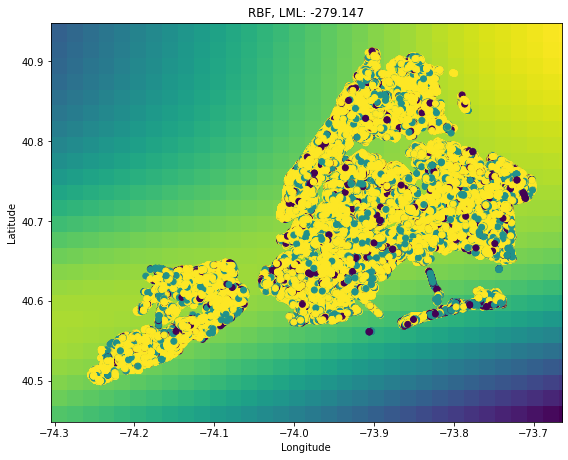

In [46]:
z_mean = z_sum / n_splits

plt.figure(figsize=(8, 8))
# Plot the predicted results. For that, we will assign a color to
# each point in the mesh [x_min, m_max]x[y_min, y_max].
plt.subplot(1, 1, 1)
# Put the result into a color plot
z_mean_r = z_mean.reshape((xx.shape[0], xx.shape[1], 1))
plt.imshow(z_mean_r, extent=(x_min, x_max, y_min, y_max), origin="lower")

# Plot also the training points
plt.scatter(data['longitude'], data['latitude'], c=data['health'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
# plt.xticks()
# plt.yticks()
plt.title("%s, LML: %.3f" % ("RBF", gp.log_marginal_likelihood_value_))

plt.tight_layout()

plt.savefig("2015_Tree LonLat-health(-1,0,0.5,1) GP.png", bbox_inches ="tight", pad_inches = 0, dpi=300)

plt.show()

In [47]:
z_mean.min()

0.48267676142507376

In [48]:
z_mean.max()

0.9640221730705703

### By Zipcode

In [145]:
zipcode = gpd.read_file('./data/ZIP_CODE_040114/ZIP_CODE_040114.shp')
zipcode['centroid'] = zipcode['geometry'].centroid
zipcode.head(2)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,centroid
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ...",POINT (1040696.262 185580.222)
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ...",POINT (1001912.872 183803.113)


In [146]:
zipcode.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [147]:
from functools import partial
import pyproj
from shapely.ops import transform

def pointProjTrans(point1, crs1='epsg:2263 - NAD83', crs2='epsg:4326') -> (float,float):
    """
    Convert the coordinate of a point in crs1 to it in crs2
    Input: x1, y1: point coordinate, 
           crs1: original crs, 
           crs2: target crs.
    Output: corresponding coordinate of the point(x1,y1) in crs2
    """
    project = partial(pyproj.transform, pyproj.Proj(init=crs1), pyproj.Proj(init=crs2))
    point2 = transform(project, point1)
    return (point2.x, point2.y)

In [148]:
lon =[]
lat =[]
for i in range(len(zipcode)):
    x, y = pointProjTrans(zipcode.iloc[i].centroid)
    lon.append(x)
    lat.append(y)
zipcode['longitude'] = lon
zipcode['latitude'] = lat

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

In [149]:
zipcode.head(2)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,centroid,longitude,latitude
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ...",POINT (1040696.262 185580.222),-73.796503,40.675872
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ...",POINT (1001912.872 183803.113),-73.936327,40.671156


In [169]:
healthbyZip = data[['zipcode','health_class','comlaint_count']].groupby(['zipcode']).mean().rename(columns={'health_class':'average_health'})
healthbyZip.reset_index(inplace=True)
data2 = healthbyZip.merge(zipcode[['ZIPCODE','centroid','longitude','latitude']], left_on='zipcode', right_on='ZIPCODE')
data2.head()

,zipcode,average_health,comlaint_count,ZIPCODE,centroid,longitude,latitude
0,10001,0.904368,67.0,10001,POINT (985100.719 212599.489),-73.996930,40.750213
1,10002,0.856413,219.0,10002,POINT (988220.438 200190.136),-73.985677,40.716151
2,10003,0.854058,291.0,10003,POINT (987340.306 205944.672),-73.988850,40.731947
3,10004,0.901709,1.0,10004,POINT (980687.983 195570.587),-74.012847,40.703472
4,10004,0.901709,1.0,10004,POINT (972943.223 193858.633),-74.040777,40.698767


In [170]:
x_min, x_max = data2['longitude'].min() - 0.05, data2['longitude'].max() + 0.05
y_min, y_max = data2['latitude'].min() - 0.05, data2['latitude'].max() + 0.05

h = .005  # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [171]:
x = data2['longitude']
y = data2['latitude']
z = data2['average_health']

kernel = 1. * RBF(length_scale=[1.0,1.0], length_scale_bounds=[(1e-3, 1e3),(1e-3, 1e3)]) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))
gp = GaussianProcessRegressor(kernel=kernel,random_state=1)

gp.fit(np.c_[x,y], z)
z_pred= gp.predict(np.c_[xx.ravel(), yy.ravel()])

print('Optimized kernel: ', gp.kernel_)
print('Log marginal likelihood: ', gp.log_marginal_likelihood_value_)

Optimized kernel:  0.636**2 * RBF(length_scale=[0.802, 0.229]) + WhiteKernel(noise_level=0.00191)
Log marginal likelihood:  297.5252841615536


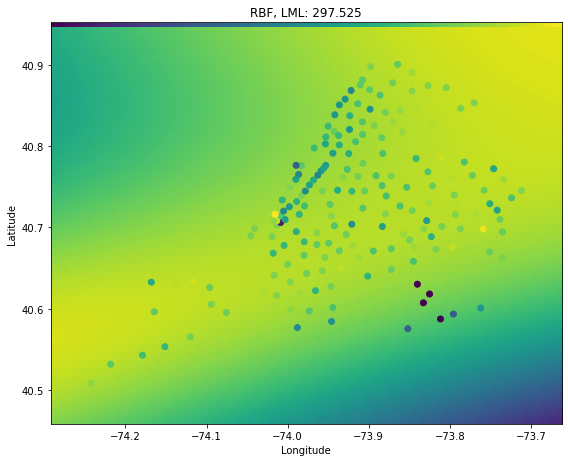

In [174]:
plt.figure(figsize=(8, 8))
# Plot the predicted results. For that, we will assign a color to
# each point in the mesh [x_min, m_max]x[y_min, y_max].
plt.subplot(1, 1, 1)
# Put the result into a color plot
z_pred_r = np.append(z_pred, np.linspace(0,1,xx.shape[1])).reshape((xx.shape[0]+1, xx.shape[1], 1))
plt.imshow(z_pred_r, extent=(x_min, x_max, y_min, y_max), origin="lower")

# Plot also the training points
plt.scatter(data2['longitude'], data2['latitude'], c=data2['average_health'], cmap='viridis')
# plt.scatter(data2['longitude'], data2['latitude'], c=data2['comlaint_count'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max()+h)
# plt.xticks()
# plt.yticks()
plt.title("%s, LML: %.3f" % ("RBF", gp.log_marginal_likelihood_value_))

plt.tight_layout()

plt.savefig("2015_Tree Zipcodelevel-health GP.png", bbox_inches ="tight", pad_inches = 0, dpi=300)

plt.show()

In [162]:
z_pred.min(), z_pred.max()

(0.11386466827153896, 0.9529465661168715)

### Most Common Family

In [185]:
top5spcs = originalData[['spc_common','tree_id']].groupby('spc_common').count().rename(columns={'tree_id':'amount'})\
                                            .sort_values(by='amount',ascending=False)[:5].reset_index()
                                            
top5spcs

,spc_common,amount
0,London planetree,86568
1,honeylocust,62939
2,Callery pear,58392
3,pin oak,52594
4,Norway maple,33573


In [106]:
top5families = originalData[['family','tree_id']].groupby('family').count().rename(columns={'tree_id':'amount'})\
                                            .sort_values(by='amount',ascending=False)[:5].reset_index()
                                            
top5families

,family,amount
0,Rosaceae,124583
1,Fabaceae,93898
2,Aceraceae,87764
3,Platanaceae,86568
4,Fagaceae,83734


In [8]:
Rosaceae = data[data['family'] == 'Rosaceae']
Rosaceae.head(2)

,family,latitude,longitude,zipcode,health,health_class
23,Rosaceae,40.723229,-73.843754,11375,Good,1.0
24,Rosaceae,40.719463,-73.835822,11375,Good,1.0


In [9]:
x_min, x_max = Rosaceae['longitude'].min() - 0.05, Rosaceae['longitude'].max() + 0.05
y_min, y_max = Rosaceae['latitude'].min() - 0.05, Rosaceae['latitude'].max() + 0.05

h = .02  # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

z_sum = [0] * (xx.shape[0] * xx.shape[1])

In [10]:
cnt = 0
n_splits = 25

kf = KFold(n_splits=n_splits, random_state=None, shuffle=True)
for train_index, test_index in kf.split(Rosaceae):
    x = Rosaceae['longitude'].iloc[test_index]
    y = Rosaceae['latitude'].iloc[test_index]
    z = Rosaceae['health_class'].iloc[test_index]

    kernel = 1. * RBF(length_scale=[1.0,1.0], length_scale_bounds=[(1e-3, 1e3),(1e-3, 1e3)]) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))
    gp = GaussianProcessRegressor(kernel=kernel,random_state=1)

    gp.fit(np.c_[x,y], z)
    z_pred = gp.predict(np.c_[xx.ravel(), yy.ravel()])
    z_sum += z_pred

    cnt += 1

    print(f'Iter {cnt}: ', z_pred.min(), z_pred.max())
    print('Optimized kernel: ', gp.kernel_)
    print('Log marginal likelihood: ', gp.log_marginal_likelihood_value_)
    print('---------------------------------------------------------------------------------')

Iter 1:  0.37502721588047194 1.1233762575085038
Optimized kernel:  0.802**2 * RBF(length_scale=[1.02, 0.248]) + WhiteKernel(noise_level=0.0591)
Log marginal likelihood:  -44.53637211306341
---------------------------------------------------------------------------------
Iter 2:  0.542866153437565 1.0479103851988327
Optimized kernel:  0.839**2 * RBF(length_scale=[1.38, 0.35]) + WhiteKernel(noise_level=0.0619)
Log marginal likelihood:  -157.26030478095709
---------------------------------------------------------------------------------
Iter 3:  0.05541969355502907 0.9671711641040721
Optimized kernel:  0.641**2 * RBF(length_scale=[0.573, 0.173]) + WhiteKernel(noise_level=0.0624)
Log marginal likelihood:  -185.02912881048815
---------------------------------------------------------------------------------
Iter 4:  0.002918980890338929 0.9632112324237863
Optimized kernel:  0.671**2 * RBF(length_scale=[0.543, 0.174]) + WhiteKernel(noise_level=0.0633)
Log marginal likelihood:  -221.6396170251

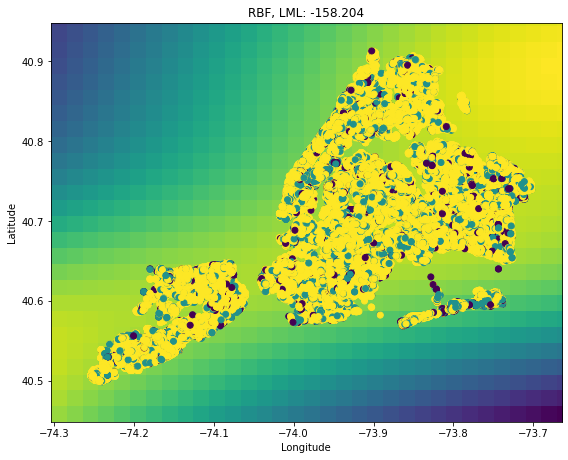

In [13]:
z_mean = z_sum / n_splits

plt.figure(figsize=(8, 8))
# Plot the predicted results. For that, we will assign a color to
# each point in the mesh [x_min, m_max]x[y_min, y_max].
plt.subplot(1, 1, 1)
# Put the result into a color plot
z_mean_r = z_mean.reshape((xx.shape[0], xx.shape[1], 1))
plt.imshow(z_mean_r, extent=(x_min, x_max, y_min, y_max), origin="lower")

# Plot also the training points
plt.scatter(Rosaceae['longitude'], Rosaceae['latitude'], c=Rosaceae['health_class'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
# plt.xticks()
# plt.yticks()
plt.title("%s, LML: %.3f" % ("RBF", gp.log_marginal_likelihood_value_))

plt.tight_layout()

plt.savefig("2015_Tree LonLat-health(-1,0,0.5,1) Rosaceae GP.png", bbox_inches ="tight", pad_inches = 0, dpi=300)

plt.show()

In [22]:
def LonLat_health_GP_single_family(spc, sample_size = 5000, mesh_step_size = 0.02):
    df = data[data['family'] == spc]

    x_min, x_max = df['longitude'].min() - 0.05, df['longitude'].max() + 0.05
    y_min, y_max = df['latitude'].min() - 0.05, df['latitude'].max() + 0.05

    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))

    z_sum = [0] * (xx.shape[0] * xx.shape[1])

    cnt = 0
    n_splits = int(np.ceil(df.shape[0] / sample_size))
    print(f"{n_splits} runs in total.")

    kf = KFold(n_splits=n_splits, random_state=None, shuffle=True)
    for train_index, test_index in kf.split(df):
        x = df['longitude'].iloc[test_index]
        y = df['latitude'].iloc[test_index]
        z = df['health_class'].iloc[test_index]

        kernel = 1. * RBF(length_scale=[1.0,1.0], length_scale_bounds=[(1e-3, 1e3),(1e-3, 1e3)]) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))
        gp = GaussianProcessRegressor(kernel=kernel,random_state=1)

        gp.fit(np.c_[x,y], z)
        z_pred = gp.predict(np.c_[xx.ravel(), yy.ravel()])
        z_sum += z_pred

        cnt += 1

        print(f'Iter {cnt}: ', z_pred.min(), z_pred.max())
        print('Optimized kernel: ', gp.kernel_)
        print('Log marginal likelihood: ', gp.log_marginal_likelihood_value_)
        print('---------------------------------------------------------------------------------')

    z_mean = z_sum / n_splits
    
    plt.figure(figsize=(8, 8))
    # Plot the predicted results. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(1, 1, 1)
    # Put the result into a color plot
    z_mean_r = z_mean.reshape((xx.shape[0], xx.shape[1], 1))
    plt.imshow(z_mean_r, extent=(x_min, x_max, y_min, y_max), origin="lower")

    # Plot also the training points
    plt.scatter(x, y, c=z, cmap='viridis')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    # plt.xticks()
    # plt.yticks()
    plt.title("%s, LML: %.3f" % ("RBF", gp.log_marginal_likelihood_value_))

    plt.tight_layout()

    plt.savefig(f"2015_Tree LonLat-health(-1,0,0.5,1) {spc} GP.png", bbox_inches ="tight", pad_inches = 0, dpi=300)

    plt.show()

Iter 1:  0.5027660201160984 0.9478385284140813
Optimized kernel:  0.736**2 * RBF(length_scale=[1.41, 0.39]) + WhiteKernel(noise_level=0.0525)
Log marginal likelihood:  252.64141673370978
---------------------------------------------------------------------------------


D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 2:  0.8216369680412958 0.9193722041566623
Optimized kernel:  0.621**2 * RBF(length_scale=[1e+03, 0.901]) + WhiteKernel(noise_level=0.049)
Log marginal likelihood:  430.348998685824
---------------------------------------------------------------------------------
Iter 3:  0.5309960314496607 0.9715206389000741
Optimized kernel:  0.675**2 * RBF(length_scale=[1.22, 0.369]) + WhiteKernel(noise_level=0.0519)
Log marginal likelihood:  280.8866527409882
---------------------------------------------------------------------------------


D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 4:  0.8829572656866418 0.923193189465195
Optimized kernel:  0.891**2 * RBF(length_scale=[1e+03, 9.98]) + WhiteKernel(noise_level=0.0507)
Log marginal likelihood:  348.8443440627034
---------------------------------------------------------------------------------
Iter 5:  0.7733752656736286 0.9451121715039577
Optimized kernel:  0.699**2 * RBF(length_scale=[1.49, 0.841]) + WhiteKernel(noise_level=0.0498)
Log marginal likelihood:  389.83574420564855
---------------------------------------------------------------------------------
Iter 6:  0.6760135271058232 0.9662935166613238
Optimized kernel:  0.749**2 * RBF(length_scale=[1.31, 0.596]) + WhiteKernel(noise_level=0.0519)
Log marginal likelihood:  285.10747493400777
---------------------------------------------------------------------------------
Iter 7:  0.525687773483412 0.9730200427382272
Optimized kernel:  0.837**2 * RBF(length_scale=[1.67, 0.379]) + WhiteKernel(noise_level=0.053)
Log marginal likelihood:  229.24144375084688
------

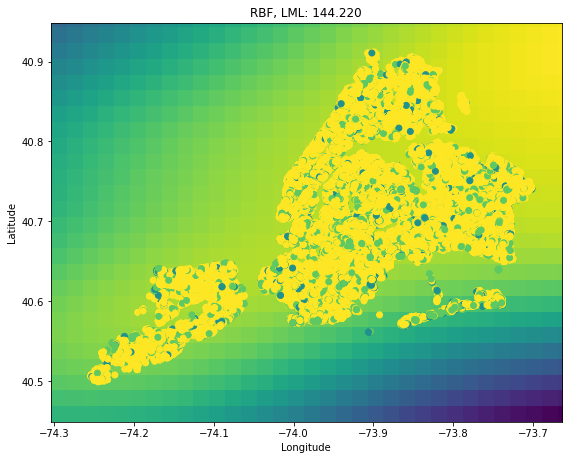

In [19]:
LonLat_health_GP_single_family('Fabaceae')

18 runs in total.
Iter 1:  0.7600040046254719 0.8642043259394683
Optimized kernel:  0.598**2 * RBF(length_scale=[0.311, 6.09]) + WhiteKernel(noise_level=0.097)
Log marginal likelihood:  -1243.604816245856
---------------------------------------------------------------------------------
Iter 2:  0.7340457963583873 1.0373725514103995
Optimized kernel:  1.01**2 * RBF(length_scale=[0.855, 4.52]) + WhiteKernel(noise_level=0.0932)
Log marginal likelihood:  -1144.6846700234828
---------------------------------------------------------------------------------
Iter 3:  0.7357936265971432 0.8993533095158206
Optimized kernel:  0.663**2 * RBF(length_scale=[0.137, 4.62]) + WhiteKernel(noise_level=0.0949)
Log marginal likelihood:  -1198.7838143542617
---------------------------------------------------------------------------------
Iter 4:  0.6133250358907674 1.1626850621019411
Optimized kernel:  0.705**2 * RBF(length_scale=[0.0963, 1.01]) + WhiteKernel(noise_level=0.0977)
Log marginal likelihood:  -1

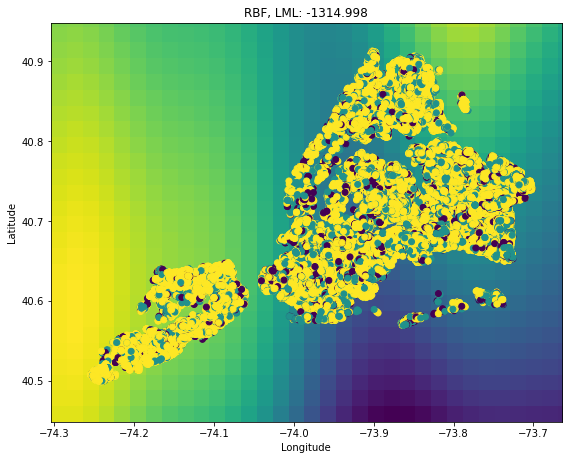

In [24]:
LonLat_health_GP_single_family('Aceraceae')

18 runs in total.
Iter 1:  -0.38441973205203794 1.0434119755144309
Optimized kernel:  0.637**2 * RBF(length_scale=[0.17, 0.13]) + WhiteKernel(noise_level=0.0467)
Log marginal likelihood:  501.0021698172959
---------------------------------------------------------------------------------
Iter 2:  -0.3834891466539396 1.0351480821451462
Optimized kernel:  0.599**2 * RBF(length_scale=[0.139, 0.135]) + WhiteKernel(noise_level=0.0441)
Log marginal likelihood:  633.2109667826653
---------------------------------------------------------------------------------
Iter 3:  -0.09506937815247696 1.0301178992305395
Optimized kernel:  0.647**2 * RBF(length_scale=[0.191, 0.201]) + WhiteKernel(noise_level=0.0494)
Log marginal likelihood:  375.9083808713758
---------------------------------------------------------------------------------
Iter 4:  -0.21582740159448832 0.9873198166011363
Optimized kernel:  0.582**2 * RBF(length_scale=[0.37, 0.17]) + WhiteKernel(noise_level=0.0501)
Log marginal likelihood: 

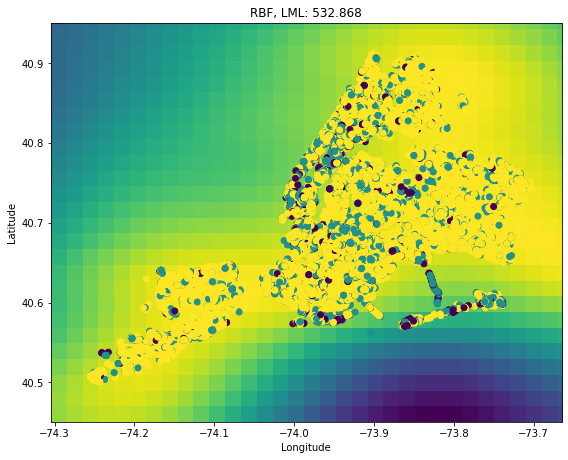

In [25]:
LonLat_health_GP_single_family('Platanaceae')

17 runs in total.
Iter 1:  0.880005087941953 0.983690911950319
Optimized kernel:  1.08**2 * RBF(length_scale=[1.01, 12.8]) + WhiteKernel(noise_level=0.0515)
Log marginal likelihood:  305.219618464047
---------------------------------------------------------------------------------
Iter 2:  0.4642824357320592 1.0408070923338997
Optimized kernel:  0.697**2 * RBF(length_scale=[0.862, 0.353]) + WhiteKernel(noise_level=0.052)
Log marginal likelihood:  272.7346111905372
---------------------------------------------------------------------------------
Iter 3:  0.44531142587217687 1.0301306587205659
Optimized kernel:  0.839**2 * RBF(length_scale=[1.5, 0.333]) + WhiteKernel(noise_level=0.051)
Log marginal likelihood:  321.85280774846615
---------------------------------------------------------------------------------
Iter 4:  0.4847122232763539 0.9692208888489873
Optimized kernel:  0.643**2 * RBF(length_scale=[0.79, 0.511]) + WhiteKernel(noise_level=0.0503)
Log marginal likelihood:  359.9115441

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 6:  0.8899171029942181 0.9126621778385129
Optimized kernel:  0.912**2 * RBF(length_scale=[21.6, 1e+03]) + WhiteKernel(noise_level=0.0539)
Log marginal likelihood:  196.13432255903172
---------------------------------------------------------------------------------
Iter 7:  0.7280064781924125 0.9418061225217116
Optimized kernel:  0.709**2 * RBF(length_scale=[1.43, 0.831]) + WhiteKernel(noise_level=0.0501)
Log marginal likelihood:  369.0155170594153
---------------------------------------------------------------------------------
Iter 8:  0.36465627204495377 1.0046286869094168
Optimized kernel:  0.719**2 * RBF(length_scale=[0.964, 0.283]) + WhiteKernel(noise_level=0.0535)
Log marginal likelihood:  204.31593753145717
---------------------------------------------------------------------------------
Iter 9:  0.5236250720165696 0.9942299111746724
Optimized kernel:  0.679**2 * RBF(length_scale=[0.79, 0.563]) + WhiteKernel(noise_level=0.053)
Log marginal likelihood:  231.36585545018897
--

D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 14:  0.9030018195225296 0.9193203314903542
Optimized kernel:  0.911**2 * RBF(length_scale=[27.3, 1e+03]) + WhiteKernel(noise_level=0.0493)
Log marginal likelihood:  415.85216492153995
---------------------------------------------------------------------------------


D:\Develop\Anaconda3\envs\geo_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 15:  0.9088707463760244 0.9089656938420205
Optimized kernel:  0.909**2 * RBF(length_scale=[1e+03, 376]) + WhiteKernel(noise_level=0.0516)
Log marginal likelihood:  307.17753167944556
---------------------------------------------------------------------------------
Iter 16:  0.6532569114805931 0.979451667236809
Optimized kernel:  0.705**2 * RBF(length_scale=[1.09, 0.792]) + WhiteKernel(noise_level=0.055)
Log marginal likelihood:  139.7492547248239
---------------------------------------------------------------------------------
Iter 17:  0.7624063069427933 0.9820568640435852
Optimized kernel:  0.797**2 * RBF(length_scale=[1.03, 0.972]) + WhiteKernel(noise_level=0.0544)
Log marginal likelihood:  165.32511820938635
---------------------------------------------------------------------------------


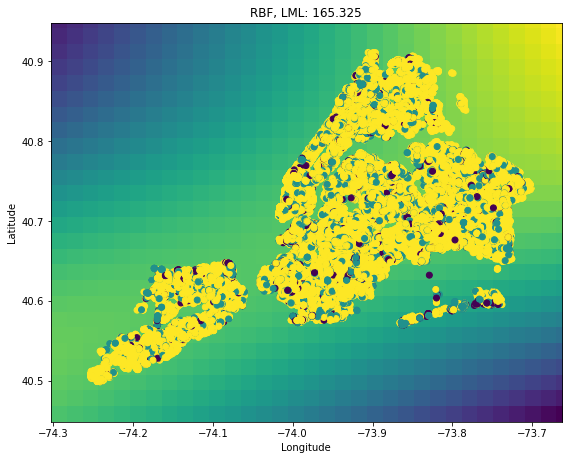

In [26]:
LonLat_health_GP_single_family('Fagaceae')

In [84]:
x_min, x_max = data['longitude'].min() - 0.05, data['longitude'].max() + 0.05
y_min, y_max = data['latitude'].min() - 0.05, data['latitude'].max() + 0.05

h = .005  # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [139]:
def LonLat_health_GP_single_family_sample(spc, sample_size = 5000):
    df = data[data['family'] == spc].sample(sample_size)

    x = df['longitude']
    y = df['latitude']
    z = df['health_class']

    kernel = 1. * RBF(length_scale=[1.0,1.0], length_scale_bounds=[(1e-3, 1e3),(1e-3, 1e3)]) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))
    gp = GaussianProcessRegressor(kernel=kernel,random_state=1)

    gp.fit(np.c_[x,y], z)
    z_pred = gp.predict(np.c_[xx.ravel(), yy.ravel()])

    print('Optimized kernel: ', gp.kernel_)
    print('Log marginal likelihood: ', gp.log_marginal_likelihood_value_)
    
    plt.figure(figsize=(8, 8))
    # Plot the predicted results. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(1, 1, 1)
    # Put the result into a color plot
    z_pred_r = np.append(z_pred, np.linspace(-1,1,xx.shape[1])).reshape((xx.shape[0]+1, xx.shape[1], 1))
    plt.imshow(z_pred_r, extent=(x_min, x_max, y_min, y_max+h), origin="lower")

    plt.scatter(x, y, c=z, cmap='viridis',s=5)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max()+2*h)
    # plt.xticks()
    # plt.yticks()
    plt.title(f"GP(RBF) on {spc} sample({sample_size}), LML: {gp.log_marginal_likelihood_value_:.3f}")

    plt.tight_layout()

    plt.savefig(f"2015_Tree LonLat-health {spc}_sample({smaple_size}) GP.png", bbox_inches ="tight", pad_inches = 0, dpi=300)

    plt.show()

In [140]:
data['family'].unique()

array(['Aceraceae', 'Platanaceae', 'Fagaceae', 'Fabaceae', 'Ulmaceae',
       'Magnoliaceae', 'Oleaceae', 'Rosaceae', 'Tiliaceae', 'Pinaceae',
       'Ginkgoaceae', 'Altingiaceae', 'Sapindaceae', 'Cupressacea',
       'Simaroubaceae', 'Cornaceae', 'Cupressaceae', 'Betulaceae',
       'Cercidiphyllaceae', 'Bignoniaceae', 'Aquifoliaceae',
       'Eucommiaceae', 'Moraceae', 'Juglandaceae', 'Nyssaceae',
       'Styracaceae', 'Lauraceae', 'Salixaceae', 'Paulowniaceae',
       'Anacardiaceae', 'Lythraceae', 'Cannabaceae', 'Hamamelidaceae',
       'Rutaceae'], dtype=object)

Optimized kernel:  0.6**2 * RBF(length_scale=[0.877, 0.179]) + WhiteKernel(noise_level=0.06)
Log marginal likelihood:  -82.88642803958919


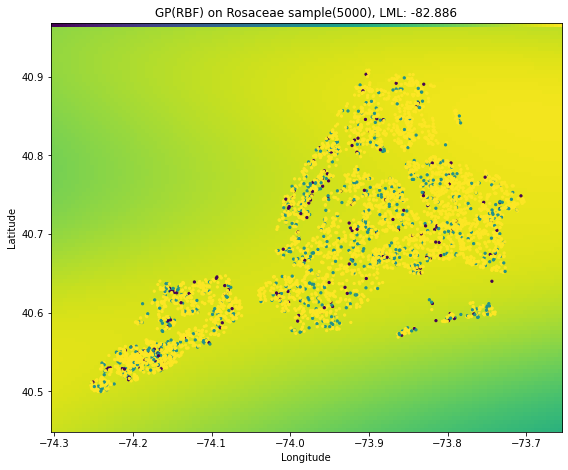

Optimized kernel:  0.687**2 * RBF(length_scale=[1.86, 0.616]) + WhiteKernel(noise_level=0.0514)
Log marginal likelihood:  313.457926170262


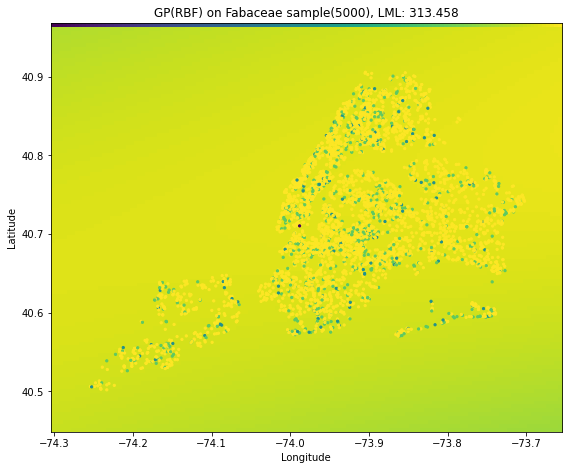

Optimized kernel:  0.556**2 * RBF(length_scale=[0.128, 0.521]) + WhiteKernel(noise_level=0.102)
Log marginal likelihood:  -1425.9117900121068


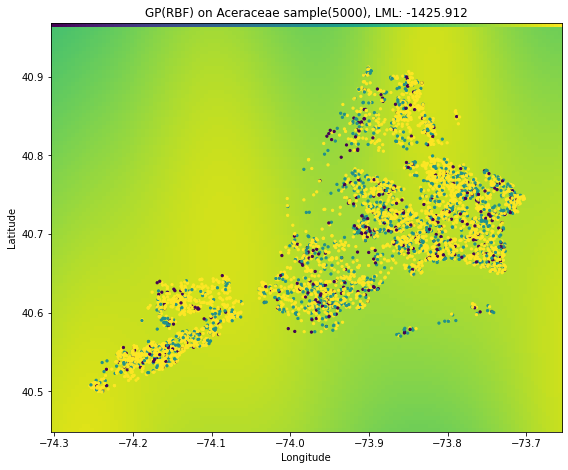

Optimized kernel:  0.544**2 * RBF(length_scale=[0.109, 0.0675]) + WhiteKernel(noise_level=0.0496)
Log marginal likelihood:  339.67827985246095


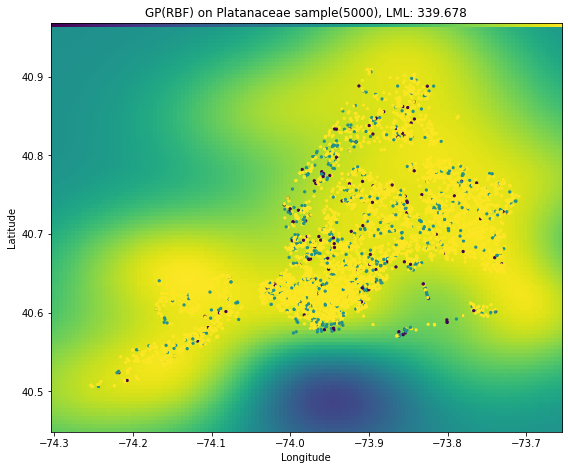

Optimized kernel:  0.728**2 * RBF(length_scale=[0.571, 0.23]) + WhiteKernel(noise_level=0.0524)
Log marginal likelihood:  254.1153524087431


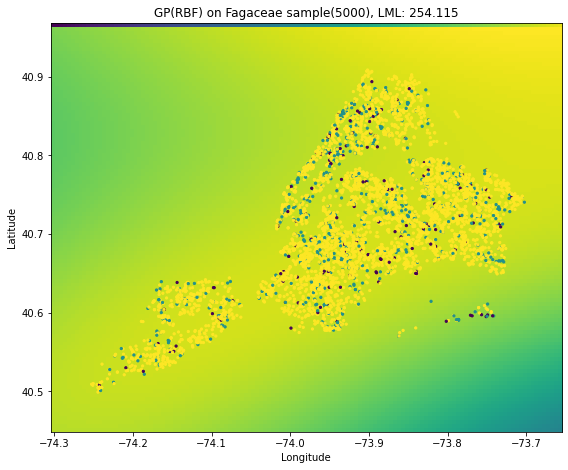

In [141]:
for spc in top5spcs.family:
# for spc in ['Aceraceae','']:
    LonLat_health_GP_single_family_sample(spc, 5000)

In [142]:
originalData.comlaint_count.unique()

array([7.830e+02, 8.750e+02, 5.140e+02, 8.820e+02, 2.340e+02, 1.310e+02,
       5.210e+02, 9.110e+02, 4.180e+02, 5.090e+02, 3.200e+02, 3.690e+02,
       5.830e+02, 4.000e+02, 3.320e+02, 1.730e+02, 2.200e+02, 1.258e+03,
       4.100e+02, 1.870e+02, 9.700e+02, 2.190e+02, 1.160e+03, 1.160e+02,
       1.051e+03, 1.980e+02, 1.430e+02, 9.620e+02, 6.860e+02, 1.558e+03,
       6.750e+02, 9.800e+02, 1.610e+02, 1.550e+02, 3.030e+02, 2.620e+02,
       2.940e+02, 5.340e+02, 3.310e+02, 7.410e+02, 2.180e+02, 5.240e+02,
       3.550e+02, 7.500e+02, 2.590e+02, 3.040e+02, 2.440e+02, 2.030e+02,
       6.430e+02, 3.080e+02, 6.180e+02, 2.920e+02, 1.420e+02, 2.580e+02,
       7.800e+01, 3.500e+01, 3.800e+02, 5.600e+01, 2.910e+02, 5.650e+02,
       3.960e+02, 1.060e+02, 4.290e+02, 3.220e+02, 4.200e+02, 1.220e+02,
       1.370e+03, 1.660e+02, 3.700e+01, 2.800e+01, 2.380e+02, 1.020e+02,
       2.240e+02, 6.460e+02, 5.440e+02, 6.310e+02, 9.800e+01, 3.640e+02,
       6.170e+02, 4.990e+02, 1.930e+02, 3.950e+02, 

In [178]:
sample_size = 5000
df = data.sample(sample_size)

x = df['longitude']
y = df['latitude']
z = df['health_class']

kernel = 1. * RBF(length_scale=[1.0,1.0], length_scale_bounds=[(1e-3, 1e3),(1e-3, 1e3)]) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))
gp = GaussianProcessRegressor(kernel=kernel,random_state=1)

gp.fit(np.c_[x,y], z)
z_pred = gp.predict(np.c_[xx.ravel(), yy.ravel()])

print('Optimized kernel: ', gp.kernel_)
print('Log marginal likelihood: ', gp.log_marginal_likelihood_value_)

Optimized kernel:  0.667**2 * RBF(length_scale=[0.886, 0.108]) + WhiteKernel(noise_level=0.0632)
Log marginal likelihood:  -219.85764166282297


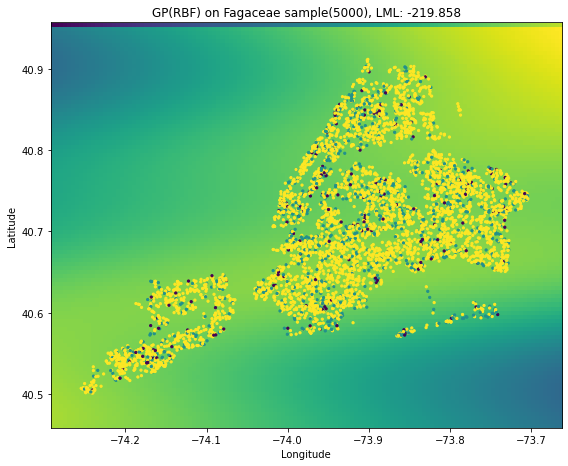

In [179]:
plt.figure(figsize=(8, 8))
# Plot the predicted results. For that, we will assign a color to
# each point in the mesh [x_min, m_max]x[y_min, y_max].
plt.subplot(1, 1, 1)
# Put the result into a color plot
z_pred_r = np.append(z_pred, np.linspace(0,1,xx.shape[1])).reshape((xx.shape[0]+1, xx.shape[1], 1))
plt.imshow(z_pred_r, extent=(x_min, x_max, y_min, y_max+h), origin="lower")

plt.scatter(x, y, c=z, cmap='viridis',s=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max()+2*h)
# plt.xticks()
# plt.yticks()
plt.title(f"GP(RBF) on all spc sample({sample_size}), LML: {gp.log_marginal_likelihood_value_:.3f}")

plt.tight_layout()

plt.savefig(f"2015_Tree LonLat-health sample({smaple_size}) GP.png", bbox_inches ="tight", pad_inches = 0, dpi=300)

plt.show()

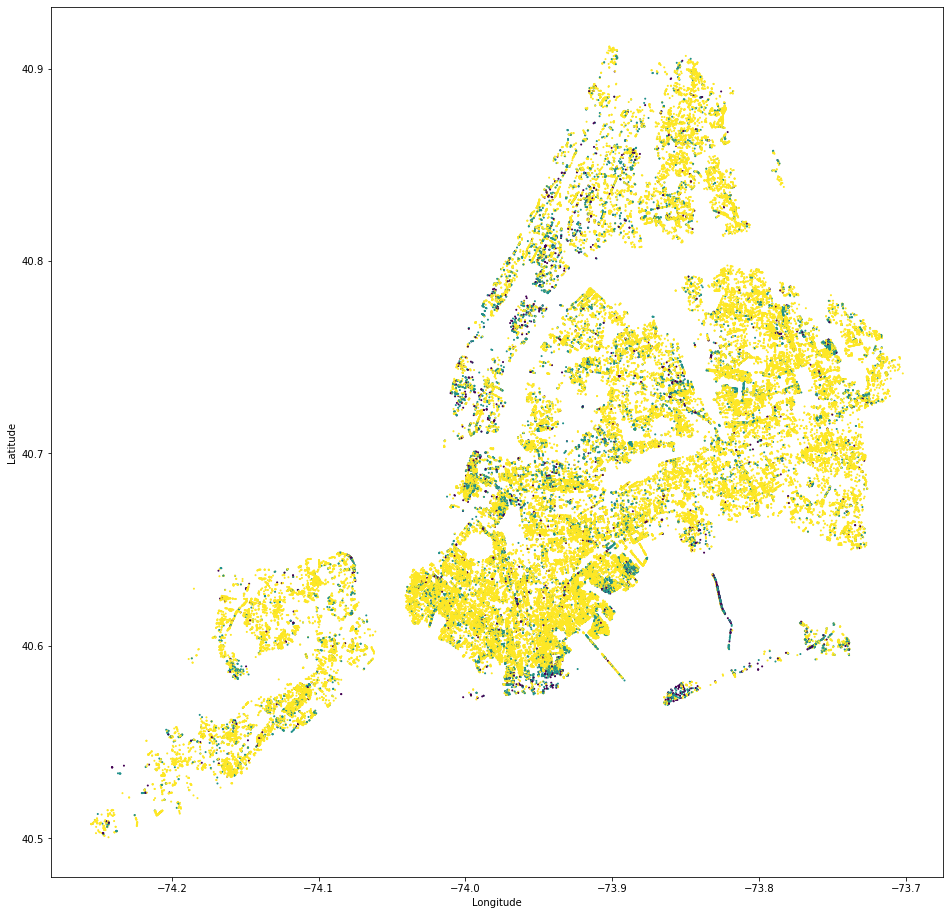

In [187]:
df = data[data['spc_common'] == 'London planetree']
x = df['longitude']
y = df['latitude']
z = df['health_class']
plt.figure(figsize=(16,16))
# Plot the predicted results. For that, we will assign a color to
# each point in the mesh [x_min, m_max]x[y_min, y_max].
plt.subplot(1, 1, 1)
# Put the result into a color plot

plt.scatter(x, y, c=z, cmap='viridis',s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [188]:
def LonLat_health_GP_single_spc_sample(spc, sample_size = 5000):
    df = data[data['spc_common'] == spc].sample(sample_size)

    x = df['longitude']
    y = df['latitude']
    z = df['health_class']

    kernel = 1. * RBF(length_scale=[1.0,1.0], length_scale_bounds=[(1e-3, 1e3),(1e-3, 1e3)]) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))
    gp = GaussianProcessRegressor(kernel=kernel,random_state=1)

    gp.fit(np.c_[x,y], z)
    z_pred = gp.predict(np.c_[xx.ravel(), yy.ravel()])

    print('Optimized kernel: ', gp.kernel_)
    print('Log marginal likelihood: ', gp.log_marginal_likelihood_value_)
    
    plt.figure(figsize=(8, 8))
    # Plot the predicted results. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(1, 1, 1)
    # Put the result into a color plot
    z_pred_r = np.append(z_pred, np.linspace(-1,1,xx.shape[1])).reshape((xx.shape[0]+1, xx.shape[1], 1))
    plt.imshow(z_pred_r, extent=(x_min, x_max, y_min, y_max+h), origin="lower")

    plt.scatter(x, y, c=z, cmap='viridis',s=5)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max()+2*h)
    # plt.xticks()
    # plt.yticks()
    plt.title(f"GP(RBF) on {spc} sample({sample_size}), LML: {gp.log_marginal_likelihood_value_:.3f}")

    plt.tight_layout()

    plt.savefig(f"2015_Tree LonLat-health {spc}_sample({smaple_size}) GP.png", bbox_inches ="tight", pad_inches = 0, dpi=300)

    plt.show()

Optimized kernel:  0.63**2 * RBF(length_scale=[0.146, 0.103]) + WhiteKernel(noise_level=0.0467)
Log marginal likelihood:  511.4228838646586


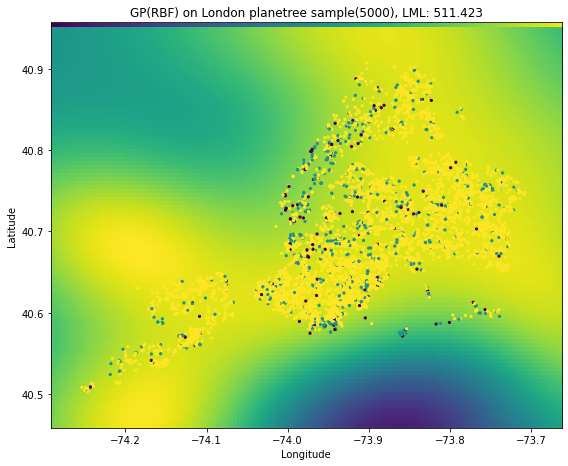

In [189]:
LonLat_health_GP_single_spc_sample('London planetree')